In [1]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,create_map, lit
from pyspark.mllib.stat import Statistics
from itertools import chain
import numpy as np
import pandas as pd
import subprocess
from functools import reduce

In [3]:
spark = SparkSession.builder.appName('practice').getOrCreate()

In [4]:
prqt_loc = '../../../../datasets/ess/parquet/'

In [5]:
p = subprocess.Popen(f'ls {prqt_loc}', shell=True, stdout=subprocess.PIPE)
ret = p.communicate()
print('Exit code: {}\nOutput:\n\n{}'.format(p.returncode, ret[0].decode('utf-8')))

Exit code: 0
Output:

ns_ESS1_180115.parquet
ns_ESS2_180115.parquet
ns_ESS3_180115.parquet
ns_ESS4_190213.parquet
ns_ESS5_180115.parquet
ns_ESS6_180115.parquet
ns_ESS7_180115.parquet
ns_ESS8_190213.parquet



In [6]:
parquets = [ pqt for pqt in ret[0].decode('utf-8').split('\n') if pqt.find('.parquet') > 0 ]

In [7]:
df = spark.read.parquet(f"{prqt_loc}*.parquet")

In [8]:
ess_year = {1:2002,2:2004,3:2006,4:2008,5:2010,6:2012,7:2014,8:2016}

In [9]:
mapping_expr = create_map([lit(x) for x in chain(*ess_year.items())])

In [10]:
col_num = ['ppltrst','pplfair','trstprl','trstep','sclmeet','health','sclmeet','partner','emprelp','happy','sclmeet']
col_bin = ['vote','pbldmn','rlgblg']
col_sum = ['agea'] + col_num + col_bin

In [11]:
df2 = df.withColumn('essround', mapping_expr[df['essround']]).filter(col('cntry')=='HU'). \
        select(col_sum).filter(col('agea')<100).filter( reduce(lambda x,y: x & y ,(col(x) <11 for x in col_num ))). \
        filter( reduce(lambda x,y: x & y ,(col(x) <3 for x in col_bin ))).filter(reduce(lambda x,y: x & y ,(col(x).isNotNull() for x in col_sum )))

In [12]:
df_ds = df2.describe().toPandas().T
df_ds.rename(columns=df_ds.iloc[0]).drop(df_ds.index[0])

,count,mean,stddev,min,max
agea,7083,48.09614570097416,17.208431715564316,15.0,93.0
ppltrst,7083,4.428914301849499,2.386981019826457,0.0,10.0
pplfair,7083,4.803755470845687,2.33622613856781,0.0,10.0
trstprl,7083,4.027530707327403,2.613793476711075,0.0,10.0
trstep,7083,4.806861499364676,2.5215755389059353,0.0,10.0
sclmeet,7083,3.593392630241423,1.6587155579933488,1.0,7.0
health,7083,2.5229422561061696,0.9451956343853101,1.0,9.0
sclmeet,7083,3.593392630241423,1.6587155579933488,1.0,7.0
partner,7083,1.399689397148101,0.5854634773339575,1.0,9.0
emprelp,7083,4.171255117887901,2.3819566598133792,1.0,9.0


In [13]:
variables = df2.columns
features = df2.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = variables, variables

In [14]:
import seaborn as sns
%matplotlib inline

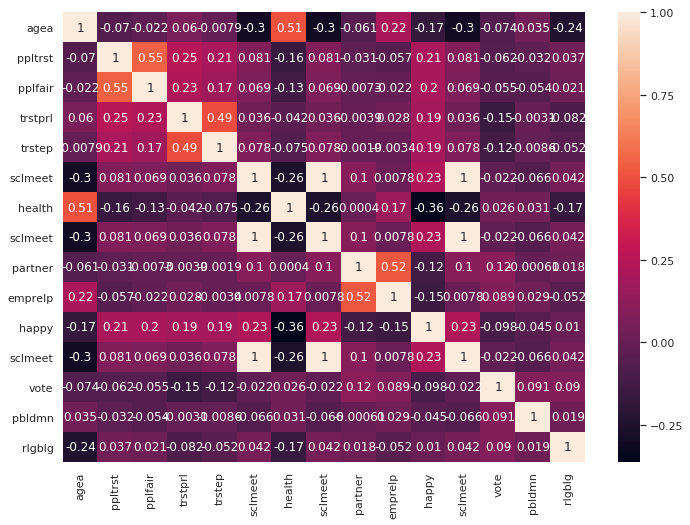

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr_df, annot=True)

In [16]:
train_df,test_df = ( df2.randomSplit(weights=[0.8, 0.2],seed=42) )

In [17]:
inp_var = df2.columns
inp_var.remove('happy')

In [18]:
features_va = VectorAssembler(inputCols = inp_var,
                              outputCol = 'variables' )

In [19]:
lin_reg  = LinearRegression(featuresCol = 'variables',
                            labelCol='happy',
                            maxIter=10,
                            regParam=0.4,
                            elasticNetParam=0.7)

In [20]:
model = Pipeline(
                stages=[features_va, lin_reg]
                ).fit(train_df)

In [21]:
pd.DataFrame({'variables':inp_var,'Coefficients':model.stages[-1].coefficients})

,variables,Coefficients
0,agea,0.000000
1,ppltrst,0.007674
2,pplfair,0.030051
3,trstprl,0.028511
4,trstep,0.027582
5,sclmeet,0.019640
6,health,-0.506005
7,sclmeet,0.019640
8,partner,-0.014829
9,emprelp,0.000000


In [22]:
print("Intercept: " + str(model.stages[-1].intercept))

Intercept: 7.001628211649343


In [23]:
model.stages[-1].summary.rootMeanSquaredError

2.1070842024092564

In [24]:
model.stages[-1].summary.r2

0.1520151169692927

In [25]:
lin_reg_predictions = model.transform(test_df)

In [26]:
lin_reg_predictions.select("prediction","happy","variables").show(5)

+-----------------+-----+--------------------+
|       prediction|happy|           variables|
+-----------------+-----+--------------------+
|6.735469619088468|  3.0|[21.0,1.0,2.0,5.0...|
|6.645018224008672|  7.0|[21.0,4.0,3.0,3.0...|
|6.526235882588407|  8.0|[22.0,3.0,8.0,1.0...|
|5.823380776661073| 10.0|[25.0,0.0,5.0,0.0...|
|6.516198097791508|  5.0|[25.0,2.0,4.0,1.0...|
+-----------------+-----+--------------------+
only showing top 5 rows



In [27]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="happy",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lin_reg_predictions))

R Squared (R2) on test data = 0.152196


In [28]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="happy",metricName="rmse")
print("RMSE on test data = %g" % lr_evaluator.evaluate(lin_reg_predictions))

RMSE on test data = 2.08328
